<a href="https://colab.research.google.com/github/elmahygurl/CIFAR10-Classification/blob/main/Transfer_Learning_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
#from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
# Hyper-parameters
num_epochs = 30
batch_size = 128
learning_rate = 0.001

In [ ]:
# preprocessing of images
transform = transforms.Compose([
    transforms.Resize(32),  # resize images to 32 so all images have same size
    #transforms.CenterCrop(28),  # get the middle 28 pixels to remove background noise
    transforms.ToTensor(),  # convert the images data type to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])      # normalize by removing mean values of RGB



In [ ]:
#splitting cifar-10 dataset to train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,num_workers=2) #false to avoid data leakage

100%|██████████| 170498071/170498071 [00:13<00:00, 12227753.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class CustomANN(nn.Module):
    def __init__(self):       # defining the layers of the neural network
        super(CustomANN, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 4096) #image is 224x224 pixels and has 3 input channels
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 512)
        self.fc4 = nn.Linear(512, 10)  # Output layer for the 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input into 1 dimension
        x = torch.relu(self.fc1(x)) #apply ReLu activation to first hidden layer
        x = torch.relu(self.fc2(x)) #to second  hidden layer
        x = torch.relu(self.fc3(x)) #to third hidden layer
        x = self.fc4(x)         # Output layer with no activation function applied
        return x

ann = CustomANN()


In [ ]:
# defining the optimizer for updating the model's parameters during training
optimizer = optim.SGD(ann.parameters(), lr=0.001, momentum=0.9) # momentum smooths out noisy gradients  by taking 90 percent from the prev one- Stochastic Gradient Descent
criterion = nn.CrossEntropyLoss()


In [ ]:
#training loop for ANN
ann.to(device)
ann.train()   #setting model in training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i, data in enumerate(trainloader, 0):   #iterating through the batches in the trainloader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = ann(inputs) #Forward pass
        loss = criterion(outputs, labels)   #computing loss
        loss.backward()   #backpropagation and updating weights
        optimizer.step()

        running_loss += loss.item() #updating loss and accuracy metrics
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_samples * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Finished training")



Epoch [1/30] - Loss: 1.8104, Accuracy: 36.02%
Epoch [2/30] - Loss: 1.5031, Accuracy: 46.99%
Epoch [3/30] - Loss: 1.3647, Accuracy: 52.41%
Epoch [4/30] - Loss: 1.2556, Accuracy: 55.97%
Epoch [5/30] - Loss: 1.1593, Accuracy: 59.29%
Epoch [6/30] - Loss: 1.0679, Accuracy: 62.71%
Epoch [7/30] - Loss: 0.9812, Accuracy: 65.72%
Epoch [8/30] - Loss: 0.8924, Accuracy: 68.94%
Epoch [9/30] - Loss: 0.8117, Accuracy: 71.77%
Epoch [10/30] - Loss: 0.7274, Accuracy: 74.77%
Epoch [11/30] - Loss: 0.6525, Accuracy: 77.14%
Epoch [12/30] - Loss: 0.5782, Accuracy: 79.92%
Epoch [13/30] - Loss: 0.5128, Accuracy: 82.47%
Epoch [14/30] - Loss: 0.4476, Accuracy: 84.44%
Epoch [15/30] - Loss: 0.3937, Accuracy: 86.33%
Epoch [16/30] - Loss: 0.3453, Accuracy: 88.19%
Epoch [17/30] - Loss: 0.3034, Accuracy: 89.70%
Epoch [18/30] - Loss: 0.2631, Accuracy: 90.95%
Epoch [19/30] - Loss: 0.2261, Accuracy: 92.46%
Epoch [20/30] - Loss: 0.2009, Accuracy: 93.14%
Epoch [21/30] - Loss: 0.1767, Accuracy: 94.17%
Epoch [22/30] - Loss: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the Network
correct = 0
total = 0
all_predicted = []  #list to store predicted labels
all_labels = []   #list to store actual labels
ann.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs =ann(images)   #forward pass and prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)   #updating total and correct counts for accuracy calculation
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

print(f'Accuracy of the network: {100 * correct / total:.2f}%')

# calculating and printing the Confusion Matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(confusion)

#calculating and printing Classification Report (Precision, Recall, F1-score, Support)
target_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
report = classification_report(all_labels, all_predicted, target_names=target_names)
print("Classification Report for ANN:")
print(report)


Accuracy of the network: 54.81%
Confusion Matrix:
[[644  41  84  17  33   9  14  22  93  43]
 [ 38 668   8  29  10  16   5  37  55 134]
 [ 65  24 443  87 102 117  41  80  18  23]
 [ 26  21  93 434  61 187  51  71  20  36]
 [ 38  12 109  95 479  67  45 108  22  25]
 [ 17   5  90 222  65 467  25  74  16  19]
 [ 12  23  84 161  74  78 477  45  19  27]
 [ 36  17  55  71  66  87   9 617   2  40]
 [ 79  63  20  37  20  11   5  17 699  49]
 [ 41 184  23  53   9  20   6  54  57 553]]
Classification Report for ANN:
              precision    recall  f1-score   support

       plane       0.65      0.64      0.65      1000
         car       0.63      0.67      0.65      1000
        bird       0.44      0.44      0.44      1000
         cat       0.36      0.43      0.39      1000
        deer       0.52      0.48      0.50      1000
         dog       0.44      0.47      0.45      1000
        frog       0.70      0.48      0.57      1000
       horse       0.55      0.62      0.58      1000
 

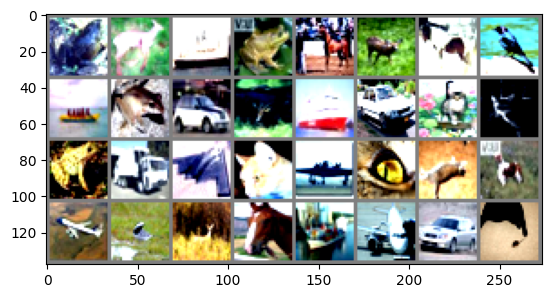

In [ ]:
#visualising
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    #transpose image for proper display
    plt.show()


# get some random training images
dataiter = iter(trainloader)    #getting an iterator for the training data
images, labels = next(dataiter) #next batch

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
#defining pretrained models
vgg16 = models.vgg16(pretrained=True)
googlenet = models.googlenet(pretrained=True)
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.

In [ ]:
# modify classification layers for CIFAR-10
num_classes = 10  # CIFAR-10 has 10 classes
in_features = vgg16.classifier[6].in_features  # Get number of input features of last fully connected layer
vgg16.classifier[6] = nn.Linear(in_features, num_classes)  # Change the last fully connected layer
googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

In [ ]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.SGD(vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9)
optimizer_google = optim.SGD(googlenet.parameters(), lr=learning_rate, momentum=0.9)
optimizer_resnet = optim.SGD(resnet50.parameters(), lr=learning_rate, momentum=0.9)


In [ ]:
#training loop for Resnet50
resnet50.to(device)
resnet50.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_resnet.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #new_weight = old_weight - learning_rate * gradient
        optimizer_resnet.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_samples * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Finished training")

Epoch [1/30] - Loss: 0.3031, Accuracy: 89.51%
Epoch [2/30] - Loss: 0.2134, Accuracy: 92.61%
Epoch [3/30] - Loss: 0.1591, Accuracy: 94.41%
Epoch [4/30] - Loss: 0.1273, Accuracy: 95.62%
Epoch [5/30] - Loss: 0.0962, Accuracy: 96.69%
Epoch [6/30] - Loss: 0.0785, Accuracy: 97.29%
Epoch [7/30] - Loss: 0.0642, Accuracy: 97.86%
Epoch [8/30] - Loss: 0.0558, Accuracy: 98.05%
Epoch [9/30] - Loss: 0.0485, Accuracy: 98.33%
Epoch [10/30] - Loss: 0.0411, Accuracy: 98.65%
Epoch [11/30] - Loss: 0.0323, Accuracy: 98.92%
Epoch [12/30] - Loss: 0.0325, Accuracy: 98.90%
Epoch [13/30] - Loss: 0.0279, Accuracy: 99.09%
Epoch [14/30] - Loss: 0.0229, Accuracy: 99.24%
Epoch [15/30] - Loss: 0.0207, Accuracy: 99.32%
Epoch [16/30] - Loss: 0.0202, Accuracy: 99.34%
Epoch [17/30] - Loss: 0.0209, Accuracy: 99.30%
Epoch [18/30] - Loss: 0.0188, Accuracy: 99.37%
Epoch [19/30] - Loss: 0.0168, Accuracy: 99.47%
Epoch [20/30] - Loss: 0.0169, Accuracy: 99.45%
Epoch [21/30] - Loss: 0.0135, Accuracy: 99.57%
Epoch [22/30] - Loss: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the Network
correct = 0
total = 0
all_predicted = []
all_labels = []
resnet50.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs =resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

print(f'Accuracy of the network: {100 * correct / total:.2f}%')

# Calculate and Print the Confusion Matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(confusion)

# Calculate and Print Classification Report (Precision, Recall, F1-score, Support)
target_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
report = classification_report(all_labels, all_predicted, target_names=target_names)
print("Classification Report for RESNET50:")
print(report)


Accuracy of the network: 84.95%
Confusion Matrix:
[[861  13  16   6  17   5   5   6  40  31]
 [ 12 902   1   6   0   3   2   4  16  54]
 [ 24   0 823  34  46  30  23  11   3   6]
 [ 11   3  42 690  31 149  34  27   6   7]
 [  6   1  30  38 830  34  17  39   5   0]
 [  4   1  12 108  22 795  14  35   3   6]
 [  4   0  18  32  24  13 896   3   6   4]
 [ 10   1  13  25  30  38   4 872   1   6]
 [ 26  11   7   8   4   3   2   3 916  20]
 [ 12  37   7   8   0   5   1   7  13 910]]
Classification Report for RESNET50:
              precision    recall  f1-score   support

       plane       0.89      0.86      0.87      1000
         car       0.93      0.90      0.92      1000
        bird       0.85      0.82      0.84      1000
         cat       0.72      0.69      0.71      1000
        deer       0.83      0.83      0.83      1000
         dog       0.74      0.80      0.77      1000
        frog       0.90      0.90      0.90      1000
       horse       0.87      0.87      0.87      1

In [ ]:
#training loop for GoogLeNet
googlenet.to(device)
googlenet.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_google.zero_grad()
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_google.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_samples * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Finished training")


Epoch [1/30] - Loss: 1.2831, Accuracy: 54.62%
Epoch [2/30] - Loss: 0.8341, Accuracy: 71.31%
Epoch [3/30] - Loss: 0.6741, Accuracy: 76.75%
Epoch [4/30] - Loss: 0.5732, Accuracy: 80.22%
Epoch [5/30] - Loss: 0.4860, Accuracy: 83.21%
Epoch [6/30] - Loss: 0.4229, Accuracy: 85.23%
Epoch [7/30] - Loss: 0.3637, Accuracy: 87.37%
Epoch [8/30] - Loss: 0.3091, Accuracy: 89.36%
Epoch [9/30] - Loss: 0.2708, Accuracy: 90.58%
Epoch [10/30] - Loss: 0.2339, Accuracy: 91.92%
Epoch [11/30] - Loss: 0.2040, Accuracy: 92.88%
Epoch [12/30] - Loss: 0.1819, Accuracy: 93.81%
Epoch [13/30] - Loss: 0.1601, Accuracy: 94.45%
Epoch [14/30] - Loss: 0.1404, Accuracy: 95.16%
Epoch [15/30] - Loss: 0.1271, Accuracy: 95.52%
Epoch [16/30] - Loss: 0.1174, Accuracy: 96.01%
Epoch [17/30] - Loss: 0.1078, Accuracy: 96.29%
Epoch [18/30] - Loss: 0.0882, Accuracy: 97.02%
Epoch [19/30] - Loss: 0.0864, Accuracy: 97.10%
Epoch [20/30] - Loss: 0.0779, Accuracy: 97.36%
Epoch [21/30] - Loss: 0.0740, Accuracy: 97.47%
Epoch [22/30] - Loss: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the Network
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs =googlenet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

print(f'Accuracy of the network: {100 * correct / total:.2f}%')

# Calculate and Print the Confusion Matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(confusion)

# Calculate and Print Classification Report (Precision, Recall, F1-score, Support)
target_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
report = classification_report(all_labels, all_predicted, target_names=target_names)
print("Classification Report for GoogleNet:")
print(report)


Accuracy of the network: 80.36%
Confusion Matrix:
[[826  10  42  19  12   7   3  11  51  19]
 [ 15 875   1   3   2   8   6   3  25  62]
 [ 37   3 755  36  60  30  44  27   4   4]
 [ 18   6  53 650  53 131  44  24  11  10]
 [ 13   2  58  46 778  23  33  40   6   1]
 [  7   2  43 112  38 730  19  39   2   8]
 [  3   6  33  56  27  24 839   3   6   3]
 [  9   1  17  41  39  43   6 831   5   8]
 [ 36  17  11   6  13   2   6   4 889  16]
 [ 23  59   5  10   5   6   4   7  18 863]]
Classification Report for GoogleNet:
              precision    recall  f1-score   support

       plane       0.84      0.83      0.83      1000
         car       0.89      0.88      0.88      1000
        bird       0.74      0.76      0.75      1000
         cat       0.66      0.65      0.66      1000
        deer       0.76      0.78      0.77      1000
         dog       0.73      0.73      0.73      1000
        frog       0.84      0.84      0.84      1000
       horse       0.84      0.83      0.84      

In [ ]:
#training loop for vgg16
vgg16.to(device)
vgg16.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_vgg.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_vgg.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_samples * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Finished training")



Epoch [1/30] - Loss: 1.8664, Accuracy: 51.08%
Epoch [2/30] - Loss: 1.9059, Accuracy: 53.41%
Epoch [3/30] - Loss: 1.9280, Accuracy: 53.60%
Epoch [4/30] - Loss: 1.9408, Accuracy: 54.01%
Epoch [5/30] - Loss: 1.9423, Accuracy: 54.27%
Epoch [6/30] - Loss: 1.9288, Accuracy: 54.57%
Epoch [7/30] - Loss: 1.9186, Accuracy: 54.79%
Epoch [8/30] - Loss: 1.9281, Accuracy: 54.63%
Epoch [9/30] - Loss: 1.9337, Accuracy: 54.47%
Epoch [10/30] - Loss: 1.9386, Accuracy: 54.57%
Epoch [11/30] - Loss: 1.9447, Accuracy: 54.69%
Epoch [12/30] - Loss: 1.9305, Accuracy: 54.68%
Epoch [13/30] - Loss: 1.9498, Accuracy: 54.43%
Epoch [14/30] - Loss: 1.9468, Accuracy: 54.17%
Epoch [15/30] - Loss: 1.9292, Accuracy: 54.78%
Epoch [16/30] - Loss: 1.9522, Accuracy: 54.53%
Epoch [17/30] - Loss: 1.9434, Accuracy: 54.70%
Epoch [18/30] - Loss: 1.9355, Accuracy: 54.60%
Epoch [19/30] - Loss: 1.9338, Accuracy: 54.91%
Epoch [20/30] - Loss: 1.9269, Accuracy: 54.68%
Epoch [21/30] - Loss: 1.9317, Accuracy: 55.02%
Epoch [22/30] - Loss: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the Network
correct = 0
total = 0
all_predicted = []
all_labels = []
vgg16.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs =vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

print(f'Accuracy of the network: {100 * correct / total:.2f}%')

# Calculate and Print the Confusion Matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(confusion)

# Calculate and Print Classification Report (Precision, Recall, F1-score, Support)
target_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
report = classification_report(all_labels, all_predicted, target_names=target_names)
print("Classification Report for VGG16:")
print(report)


Accuracy of the network: 52.46%
Confusion Matrix:
[[599  34  89  24  34  19  21  26 136  18]
 [ 52 650  19  25   9  45  23  10  50 117]
 [102  11 386  43 117 127 148  48  15   3]
 [ 30  29  80 292  59 302 135  44  20   9]
 [ 41   6 113  36 450  82 134 120  17   1]
 [ 14  16  56 116  48 638  56  41   5  10]
 [ 15   2  71  55  94  73 668  12   8   2]
 [ 49  16  73  50 117 177  30 459  12  17]
 [110  64  35  24  21  18  10  13 646  59]
 [102 233   9  24   7  37  10  31  89 458]]
Classification Report for VGG16:
              precision    recall  f1-score   support

       plane       0.54      0.60      0.57      1000
         car       0.61      0.65      0.63      1000
        bird       0.41      0.39      0.40      1000
         cat       0.42      0.29      0.35      1000
        deer       0.47      0.45      0.46      1000
         dog       0.42      0.64      0.51      1000
        frog       0.54      0.67      0.60      1000
       horse       0.57      0.46      0.51      1000